In [1]:
%pylab inline
from simqso.sqgrids import *
from simqso import sqbase
from astropy.cosmology import WMAP9

Populating the interactive namespace from numpy and matplotlib


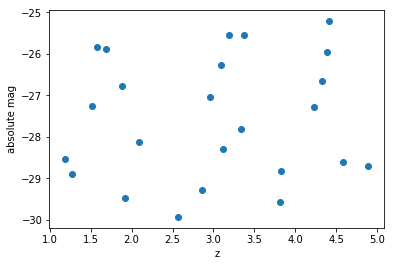

In [2]:
# set up a luminosity-redshift grid
M = AbsMagVar(GridSampler(-30,-25,nbins=4),restWave=1450)
z = RedshiftVar(GridSampler(1,5,nbins=3))
MzGrid = QsoSimGrid([M,z],2)
scatter(MzGrid.z,MzGrid.absMag)
xlabel('z')
ylabel('absolute mag')

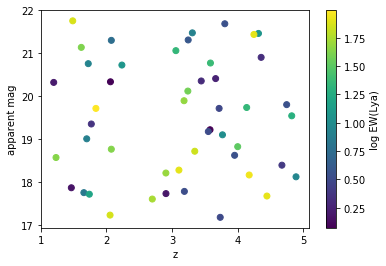

In [3]:
# set up a flux-redshift grid with Lya EW as a third dimension
m = AppMagVar(GridSampler(17,22,nbins=4),band='i')
lya = EmissionLineVar(GridSampler(0,2,nbins=2),'logLyaEW')
mzlyaGrid = QsoSimGrid([m,z,lya],2)
scatter(mzlyaGrid.z,mzlyaGrid.appMag,c=mzlyaGrid.logLyaEW)
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('log EW(Lya)')

In [4]:
# Generate m,z points by sampling from a model QLF
from simqso.lumfun import QLF_McGreer_2013
cosmo=WMAP9
m2M = lambda z: sqbase.mag2lum('SDSS-i',1450,z,cosmo)
qlfGrid = generateQlfPoints(QLF_McGreer_2013,(17,22),(4.5,5.3),m2M,cosmo,skyArea=100)
qlfGrid.addVar(AbsMagVar(FixedSampler(qlfGrid.appMag-m2M(qlfGrid.z))))

integration returned  43  objects
4  out of  43
8  out of  43
12  out of  43
16  out of  43
20  out of  43
24  out of  43
28  out of  43
32  out of  43
36  out of  43
40  out of  43


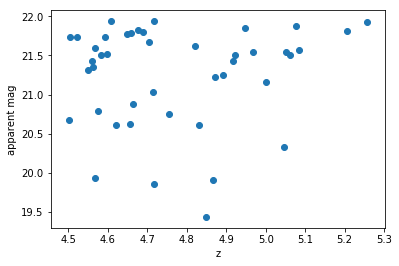

In [5]:
scatter(qlfGrid.z,qlfGrid.appMag)
xlabel('z')
ylabel('apparent mag')

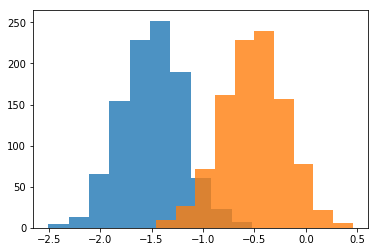

In [6]:
# test the canonical values for power law continuum slopes in FUV/NUV
contVar = BrokenPowerLawContinuumVar(GaussianSampler,[(-1.5,0.3),(-0.5,0.3)])
contVals = contVar(1000)
_ = hist(contVals[:,0],alpha=0.8)
_ = hist(contVals[:,1],alpha=0.8)

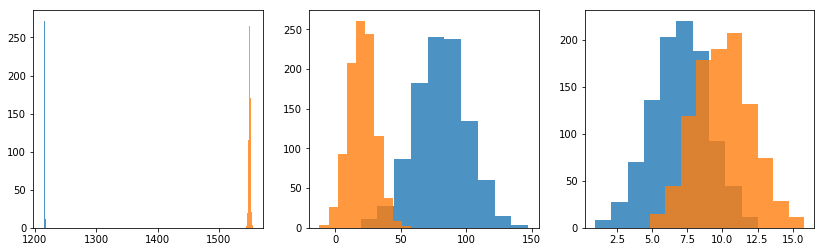

In [7]:
# Add gaussian emission lines
lya = [(1215.7,0.5),(80,20),(7,2)]
civ = [(1550.0,1.5),(20,10),(10,2)]
emLinesVar = GaussianEmissionLinesTemplateVar(GaussianSampler,[lya,civ])
emLinesVals = emLinesVar(1000)
figure(figsize=(14,4))
for k in range(3):
    subplot(1,3,k+1)
    for j in range(2):
        hist(emLinesVals[:,j,k],alpha=0.8)

In [8]:
# add gaussian lines to the qlf grid
qlfGrid.addVar(emLinesVar)
print qlfGrid

    appMag          z           absMag             emLines [2,3]         
------------- ------------- -------------- ------------------------------
19.8587712005 4.71793369699 -26.5538867384 1215.77431601 .. 10.3174688751
 21.252874349 4.89244636401 -25.2364033897 1215.96373166 .. 9.48273342804
21.9362789671  4.6071629907 -24.4261117012 1216.11449777 .. 10.0585080545
21.5209125544 4.59780126049 -24.8371690584 1216.20972513 .. 10.4047478746
21.7847694006 4.65789574611 -24.6008065842  1214.9469179 .. 13.6180295589
 21.871819443 5.07765565707 -24.6955594764 1215.31813334 .. 8.07161559695
21.9244999964 5.25560882937 -24.7150304212 1215.74552049 .. 11.7186733297
21.5653990731 5.08544945082 -25.0051975696 1216.45665356 .. 11.5084918225
20.3268827323 5.04748264334 -26.2279877453 1215.91053055 .. 8.83379279788
 21.591581998 4.56623023162 -24.7518965444 1216.31977163 .. 7.84653272141
          ...           ...            ...                            ...
21.6220483016 4.82026796198 -24.835909

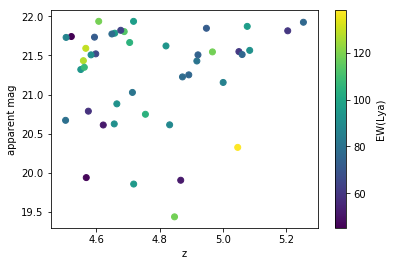

In [9]:
scatter(qlfGrid.z,qlfGrid.appMag,c=qlfGrid.emLines[:,0,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(Lya)')

In [10]:
# Now use the BOSS DR9 emission line template, including the Baldwin Effect
lineTemplate = generateBEffEmissionLines(qlfGrid.absMag)
lines = lineTemplate()
lines.shape

(43, 62, 3)

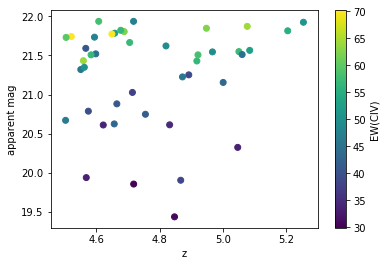

In [11]:
scatter(qlfGrid.z,qlfGrid.appMag,c=lines[:,13,1])
cb = colorbar()
xlabel('z')
ylabel('apparent mag')
cb.set_label('EW(CIV)')

In [12]:
vdblines = generateVdBCompositeEmLines(minEW=0)
vdblines = vdblines(qlfGrid.nObj)

using the following lines from VdB template:  Ly{epsilon},CIII,Ly{beta},ArI,FeIII,CIII*,Ly{alpha},NV,SiII,OI,CII,SiIV,CIV,HeII,OIII],NIV,NIII],FeII,SiII,AlIII,SiIII],CIII],FeIII,FeIII,FeII,FeII,FeII,CII],[NeIV],[OII],FeII,AlII],MgII,FeII,OIII,HeI,FeI,FeII,[NeV],[NeV],FeII,[FeVII],[OII],[FeVII],FeII,FeII,[NeIII],HeI,[NeIII],[FeV],H{delta},FeII,FeII,[FeII],[FeII],H{gamma},[OIII],FeII,FeII,HeII,H{beta},FeII,[OIII],[OIII],[FeVII],[FeVI],[NI],[FeVII],FeII,[FeXIV],[ClIII],[FeVII],HeI,[FeVII],[OI],[OI],[NII],H{alpha},[NII],[SII],[SII],HeI,[ArIII],[OII],[NiIII]


In [13]:
wave = arange(3000,1e4,0.5)
z = 2.0
def quick_spec(emlines):
    lineWave,eqWidth,sigma = emlines.T * (1+z)
    spec = np.zeros_like(wave)
    A = eqWidth/(np.sqrt(2*np.pi)*sigma)
    twosig2 = 2*sigma**2
    nsig = np.sqrt(-2*np.log(1e-3/A))
    nsig = (nsig*np.array([[-1.],[1]])).T
    for i in xrange(lineWave.shape[0]):
        i1,i2 = np.searchsorted(wave,lineWave[i]+nsig[i]*sigma[i])
        if i2 != i1:
            lineprofile = A[i]*np.exp(-(wave[i1:i2]-lineWave[i])**2
                                       / twosig2[i])
            spec[i1:i2] += lineprofile
    return spec

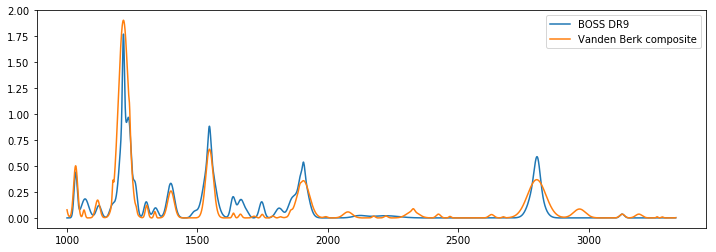

In [14]:
figure(figsize=(12,4))
plot(wave/(1+z),quick_spec(lines[0]),label='BOSS DR9')
plot(wave/(1+z),quick_spec(vdblines[0]),label='Vanden Berk composite')
legend()